## Описание

Данный проект направлен на изучение эффективности индикаторов технического анализа при торговле на фондовом рынке, оценки эффективности алгоритмических торговых стратегий инструментами анализа данных и __не несет в себе инвестиционных рекомендаций.__

В исследовании будет рассмотрена одна из наиболее популярных стратегий - сочетание MACD (Moving Average Convergence Divergence, то есть «схождение — расхождение скользящих средних») и 200 EMA (Exponential Moving Average — экспоненциальная скользящая средняя).
На основе данных индикаторов определим суть стратегии:

**Сигнал к покупке акции будет приниматься при одновременном выполнении следующих условий:**
- восходящий (бычий) тренд - цена должна быть выше 200-й экспоненциальной скользящей средней;
- пересечение MACD сигнальной линии снизу вверх, при этом рассмотрим пересечение исключительно ниже нулевой отметки

**Продажа будет осуществляться при ближайшем обратном пересечении MACD без дополнительных условий.**

На исторических данных предстоит выяснить, является ли стратегия эффективной (прибыльной), а также алгоритмизировать все процессы таким образом, чтобы программа производила анализ эффективности для любых заданных условий: тикер акции, исследуемый период, таймфрейм.

### План исследования:

* Загрузить исторические данные (выбрать тикер акции, период и торговый интервал (таймфрейм));
* Написать алгоритмы:
    * для расчета необходимых значений индикаторов;
    * определения дат и времени открытия и закрытия сделок согласно исследуемой стратегии;
* Произвести анализ финансового результата;
* Cформировать вывод

In [136]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import yfinance as yf
from datetime import date, timedelta, datetime
sns.set(rc={'figure.figsize': (15, 8)})

## Загрузка исторических данных

In [ ]:
# назначим переменную с сегодняшней датой
today = date.today().strftime("%Y-%m-%d") # текущая дата

# Устанавливаем вводные данные для выгрузки
stock = 'AMD' # выбрать тикер акции
date_from = '2021-02-01' # выбираем дату, с которой планируем собрать данные
date_to = today # дата, до которой планируется анализ
interval = '1h' # таймфрейм, выбрать из доступных [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
currency = 'USD' # валюта

In [137]:
# загружаем данные
data = yf.download(stock,
                  start = date_from,
                  end = date_to,
                  interval = interval)

# преобразуем названия колонок и округлим данные в датафрейме
data.columns = data.columns.str.lower()
data.columns = [column.replace(' ', '_') for column in data.columns]
data = round(data, 2)

[*********************100%***********************]  1 of 1 completed


In [138]:
# преобразуем названия колонок и округлим данные в датафрейме
data.columns = data.columns.str.lower()
data.columns = [column.replace(' ', '_') for column in data.columns]
data = round(data, 2)

In [139]:
data.head()

,open,high,low,close,adj_close,volume
Datetime,,,,,,
2021-02-01 09:30:00,86.42,86.50,84.66,85.67,85.67,11760318
2021-02-01 10:30:00,85.67,86.27,84.76,86.01,86.01,7686576
2021-02-01 11:30:00,86.00,86.92,85.74,86.87,86.87,5461252
2021-02-01 12:30:00,86.89,87.60,86.64,87.18,87.18,5232932
2021-02-01 13:30:00,87.18,87.32,86.82,87.10,87.10,3601414


В данной стратегии нас интересует только колонка `close` - цена при закрытии торгового интервала.

## Расчеты значений индикаторов

In [140]:
# Функция расчета скользящей средней
def EWMA(data, ndays): 
    EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean().round(4))
    return EMA

In [141]:
# Рассчитываем экспоненциальные скользящие средние, необходимые в рамках стратегии
data['ema200'] = EWMA(data,200)
data['ema12'] = EWMA(data,12)
data['ema26'] = EWMA(data,26)

In [142]:
# удалим строки, которые образовались после расчета индикаторов
data = data.dropna()

Чем больший период скользящих средних используется, тем больше данных теряется и момент анализа фактически сдвигается.

In [143]:
# В стратегии MACD мы используем две линии: линия MACD - Схождение/расхождение скользящих средних,
# которая представляет собой разницу между 26-дневной EMA и 12-дневной EMA, и сигнальную линию,
# которая является 9-дневной EMA линии MACD

# линия MACD
data['macd'] = data['ema12'] - data['ema26'] 

# сигнальная линия
data['macdsignal'] = data['macd'].ewm(span=9, adjust=False).mean()

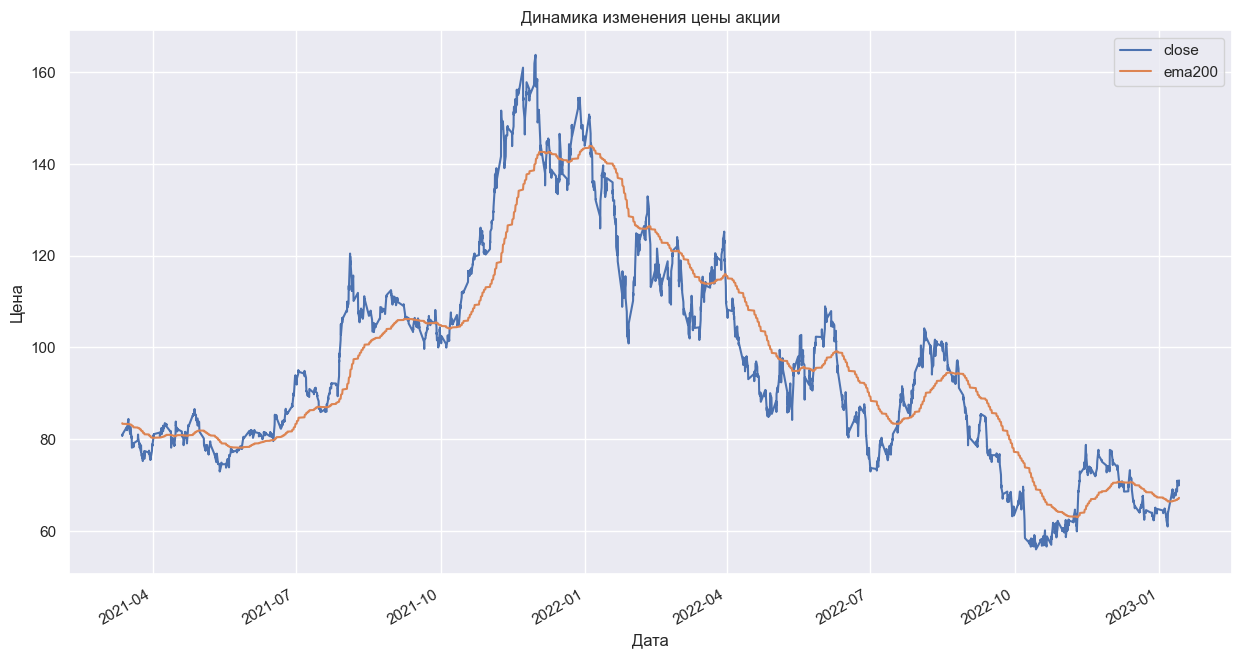

In [144]:
# построим график изменения цены, а также наложим 200-ю скользящую среднюю
data[['close', 'ema200']].plot(title = 'Динамика изменения цены акции')
plt.xlabel('Дата')
plt.ylabel('Цена');

С помощью скользящих средних определяется общий тренд. Чем больший период принимается в расчет, тем глобальнее можно увидеть картину.

Экспоненциальная скользящая средняя EMA в отличие от простой скользящей SMA (средневзвешенного значения цены за период) более гибкая, поскольку большее значение придается последним ценовым данным, таким образом она быстрее реагирует на недавние изменения цены.

Согласно стратегии для покупки рассматривается ситуация, когда цена выше значения скользящего среднего, т.е. мы ищем моменты для совершения сделки на растущем ('бычьем') рынке, в ином случае тренд низходящий ('медвежий')

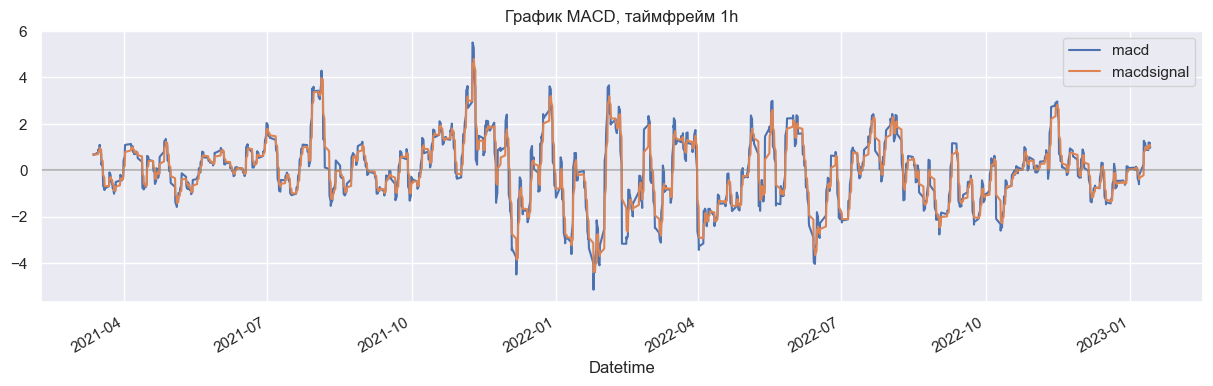

In [145]:
# также построим график MACD
data[['macd', 'macdsignal']].plot(title=f'График MACD, таймфрейм {interval}', figsize=(15,4))
plt.axhline(y=0, color='grey', linestyle='-', alpha=0.5);

Чем меньше таймфрейм (временной торговый интервал), тем больше "шума" содержит график.
Сигнал к покупке возникает при пересечении линии MACD сигнальной линии (macdsignal) снизу вверх, при условии, что это пересечение находится ниже нулевой линии.

Далее необходимо найти даты и время торговых сигналов по всем индикаторам из нашей стратегии на исторических данных.

## Создание торговых сигналов

In [146]:
data = data.reset_index()
if data.columns[0] == 'Date':
    data = data.rename(columns={'Date':'Datetime'})

In [147]:
# добавим индикатор по условию "цена выше EMA200"
data['ema200_signal'] = np.where(data['close'] > data['ema200'], 'buy', 'sell')

In [148]:
# далее найдем пересечения линий MACD и сигнальной линии
# и обозначим сигналы к покупке и продаже в зависимости от типа пересечения ('buy' или 'sell')
# в анализе не будем учитывать первую строку, поскольку у нас нет данных за предыдущий интервал

cross_macd_sign = []
for i in range(1, len(data)):
    if data['macd'][i] > data['macdsignal'][i] and data['macd'][i-1] < data['macdsignal'][i-1]:
        cross_macd_sign.append('buy')
    elif data['macd'][i] < data['macdsignal'][i] and data['macd'][i-1] > data['macdsignal'][i-1]:
        cross_macd_sign.append('sell')
    else:
        cross_macd_sign.append('no_signal')
        
# для первой строки укажем 'no_signal'
cross_macd_sign.insert(0, "no_signal")

# и добавим колонку с сигналами MACD в датафрейм
data['cross_macd_sign'] = cross_macd_sign

In [149]:
# выберем из всего датафрейма строки, удовлетворяющие условиям стратегии, т.е. когда одновременно выполняются все условия
# вынесем в отдельный датафрейм
trade_data = data[(data['cross_macd_sign'] == "buy") & (data['ema200_signal'] == "buy") | (data['cross_macd_sign'] == 'sell')]
trade_data = trade_data.reset_index(drop=True)

In [150]:
trade_data.head()

,Datetime,open,high,low,close,adj_close,volume,ema200,ema12,ema26,macd,macdsignal,ema200_signal,cross_macd_sign
0,2021-03-12 13:30:00,80.92,81.09,80.64,80.83,80.83,2634969,83.3901,80.4518,79.7792,0.6726,0.684392,sell,sell
1,2021-03-16 14:30:00,82.57,83.14,82.25,83.00,83.00,5716387,83.2768,82.8073,81.8797,0.9276,0.956270,sell,sell
2,2021-03-23 12:30:00,78.87,79.26,78.74,78.81,78.81,3258686,82.2704,79.5180,79.8545,-0.3365,-0.300377,sell,sell
3,2021-03-30 10:30:00,75.46,75.99,75.30,75.80,75.80,6074498,80.6638,76.6085,76.9659,-0.3574,-0.354797,sell,sell
4,2021-04-06 12:30:00,81.85,82.00,81.01,81.06,81.06,4114687,80.4260,81.2310,80.3063,0.9247,0.982354,buy,sell


Теперь в колонке `cross_macd_sign` необходимые сигналы к покупке согласно стратегии (все условия соблюдаются). Чтобы соблюдалась логика и каждая сделка была закрыта, для каждой сделки по покупке необходимо найти момент для продажи (также согласно стратегии). Таким образом, получится цепочка "покупка - продажа - покупка" и т.д.

## Формирование истории сделок

In [151]:
# составим список индексов строк с сигналами к продаже
# для каждой покупки найдем ближайшие следующие за ними сигналы 'sell'
sell_indexes = []
for i in range(0, len(trade_data)):
        if trade_data['cross_macd_sign'][i] == 'buy':
            sell_indexes.append(i+1)

In [152]:
# составим общий датафрейм с данными о покупках и продажах акций (включим в него даты и цены сделок)
# данные о покупках уже известны по сигналу 'cross_macd_sign',
# а данные о продажах возьмем из датафрейма 'trade_data' с помощью полученных индексов

buy_data = (
    trade_data[trade_data['cross_macd_sign'] == 'buy'][['Datetime', 'close']].reset_index(drop=True)
                                                                            .rename(columns={'close':'buy_price',
                                                                                            'Datetime':'buy_date'})
)

sell_data = (
    trade_data.reset_index().loc[sell_indexes][['Datetime', 'close']]
                            .reset_index(drop=True)
                            .rename(columns={'close':'sell_price',
                                            'Datetime':'sell_date'})
)

In [153]:
# и склеим 2 таблицы в одну общую
join_data = pd.concat([buy_data, sell_data.reset_index(drop=True)],axis=1)

In [154]:
join_data.head()

,buy_date,buy_price,sell_date,sell_price
0,2021-04-08 10:30:00,83.16,2021-04-09 09:30:00,83.18
1,2021-04-15 09:30:00,81.20,2021-04-19 09:30:00,81.66
2,2021-04-21 10:30:00,81.32,2021-04-22 12:30:00,79.88
3,2021-04-23 09:30:00,82.27,2021-04-27 15:30:00,85.28
4,2021-05-26 13:30:00,78.40,2021-05-27 09:30:00,78.02


In [155]:
# Добавим колонки со значением финансового результата совершенных сделок
join_data['result'] = join_data['sell_price'] - join_data['buy_price']
join_data['percent'] = round((join_data['result'] / join_data['buy_price']).mul(100), 2)
join_data['profit'] = join_data['result'] > 0

In [156]:
join_data.head()

,buy_date,buy_price,sell_date,sell_price,result,percent,profit
0,2021-04-08 10:30:00,83.16,2021-04-09 09:30:00,83.18,0.02,0.02,True
1,2021-04-15 09:30:00,81.20,2021-04-19 09:30:00,81.66,0.46,0.57,True
2,2021-04-21 10:30:00,81.32,2021-04-22 12:30:00,79.88,-1.44,-1.77,False
3,2021-04-23 09:30:00,82.27,2021-04-27 15:30:00,85.28,3.01,3.66,True
4,2021-05-26 13:30:00,78.40,2021-05-27 09:30:00,78.02,-0.38,-0.48,False


Теперь можем увидеть результат каждой сделки и отследить динамику изменения депозита.

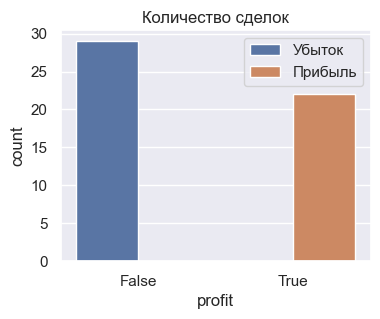

In [157]:
# Посмотрим статистику прибыльных и убыточных сделок
plt.figure(figsize=(4, 3))
sns.countplot(x="profit", hue="profit", data=join_data)
plt.title('Количество сделок')
plt.legend(labels=['Убыток', 'Прибыль']);

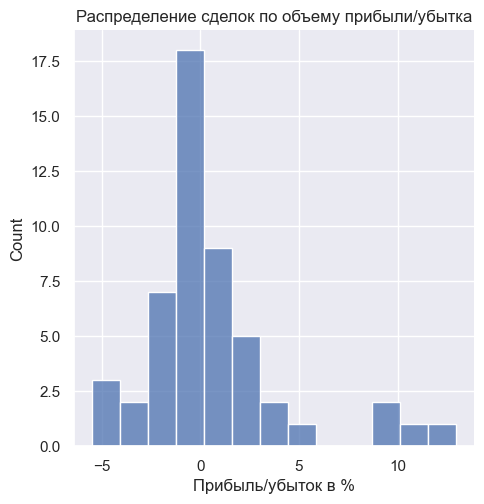

In [158]:
# Посмотрим график распределения прибыльности/убыточности сделок
sns.displot(join_data.percent)
plt.title('Распределение сделок по объему прибыли/убытка')
plt.xlabel('Прибыль/убыток в %');

**Отметим на графике полученные сигналы к покупке и продаже**

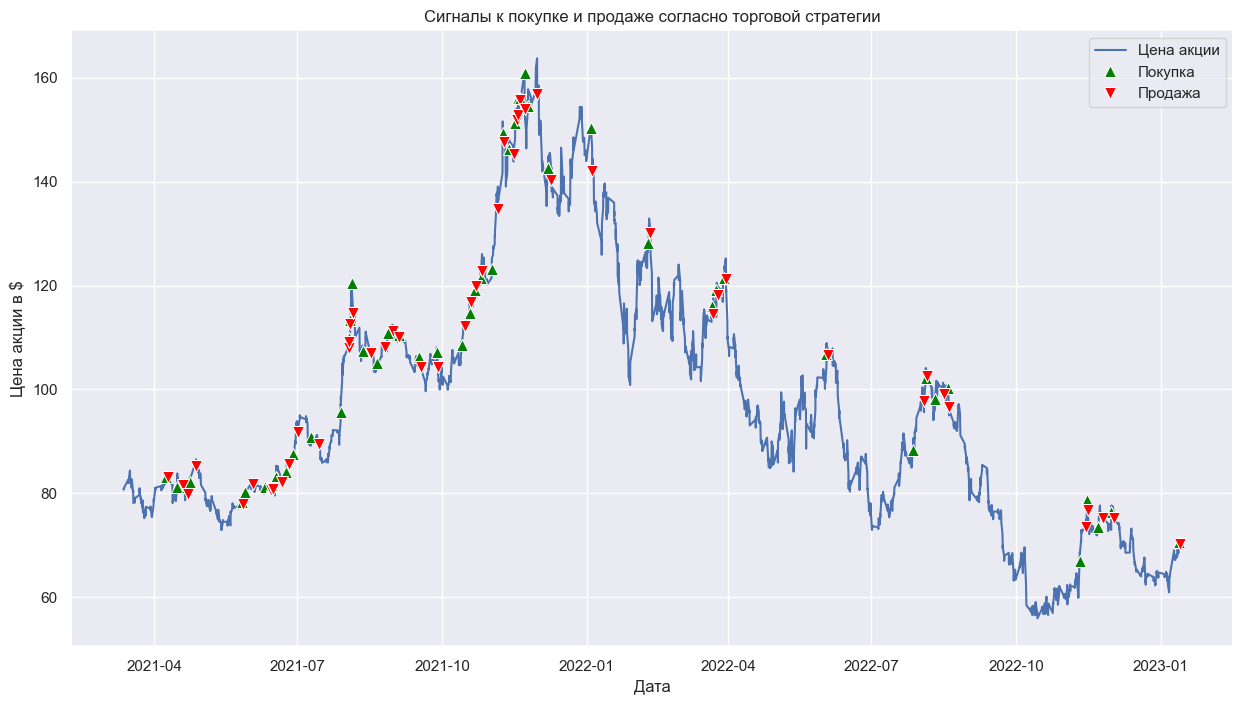

In [159]:
ax = sns.lineplot(x = 'Datetime', y = 'close', data = data)
sns.lineplot(x = 'buy_date', y = 'buy_price', data = join_data, linestyle='', marker = '^',  markersize = 8, color = 'green')
sns.lineplot(x = 'sell_date', y = 'sell_price', data = join_data, linestyle='', marker = 'v', markersize = 8, color = 'red')
ax.set_title('Сигналы к покупке и продаже согласно торговой стратегии')
ax.set_xlabel('Дата')
ax.set_ylabel('Цена акции в $')
plt.legend(loc='upper right', labels=['Цена акции', 'Покупка', 'Продажа']);


**Проведем анализ динамики изменения капитала при условии алгоритмической торговли по данной стратегии**

Для удобства расчетов экономической эффективности примем условие, что мы можем совершать сделки на весь депозит, чтобы отследить его динамику, т.е. пренебрежем тем фактом, что на реальной фондовой бирже нельзя купить или продать дробное количество ценных бумаг. Однако в нашей модели необходимо, чтобы участвовал весь капитал.

In [160]:
# произвольно определим стартовый капитал и в хронологическом порядке применим к нему результат каждой сделки
# результаты сохраним в список
start_depo = 10000

deposit = start_depo
depo = []
for deal in join_data.percent:
    deposit += deposit * (deal/100)
    depo.append(round(deposit, 2))

In [161]:
# добавим в датафрейм инфо об изменениях депозита
join_data['deposit'] = depo

In [162]:
join_data.tail()

,buy_date,buy_price,sell_date,sell_price,result,percent,profit,deposit
46,2022-11-10 10:30:00,67.08,2022-11-14 15:30:00,73.49,6.41,9.56,True,13189.39
47,2022-11-15 09:30:00,78.75,2022-11-15 13:30:00,76.84,-1.91,-2.43,False,12868.88
48,2022-11-22 10:30:00,73.59,2022-11-25 10:30:00,75.35,1.76,2.39,True,13176.45
49,2022-11-30 13:30:00,76.39,2022-12-02 10:30:00,75.22,-1.17,-1.53,False,12974.85
50,2023-01-12 11:30:00,70.59,2023-01-13 11:30:00,70.26,-0.33,-0.47,False,12913.87


In [163]:
# создадим датафрейм с историей изменения депозита
# к предыдущим данным необходимо добавить строку со стартовым депозитом (в момент первой покупки)
depo_history = join_data.buy_date[[0]].to_frame().rename(columns={'buy_date':'sell_date'})
depo_history['deposit'] = start_depo

depo_history = (
    pd.concat([depo_history, join_data[['sell_date', 'deposit']]], axis=0)
        .reset_index(drop=True)
        .rename(columns={'sell_date':'date'})
)

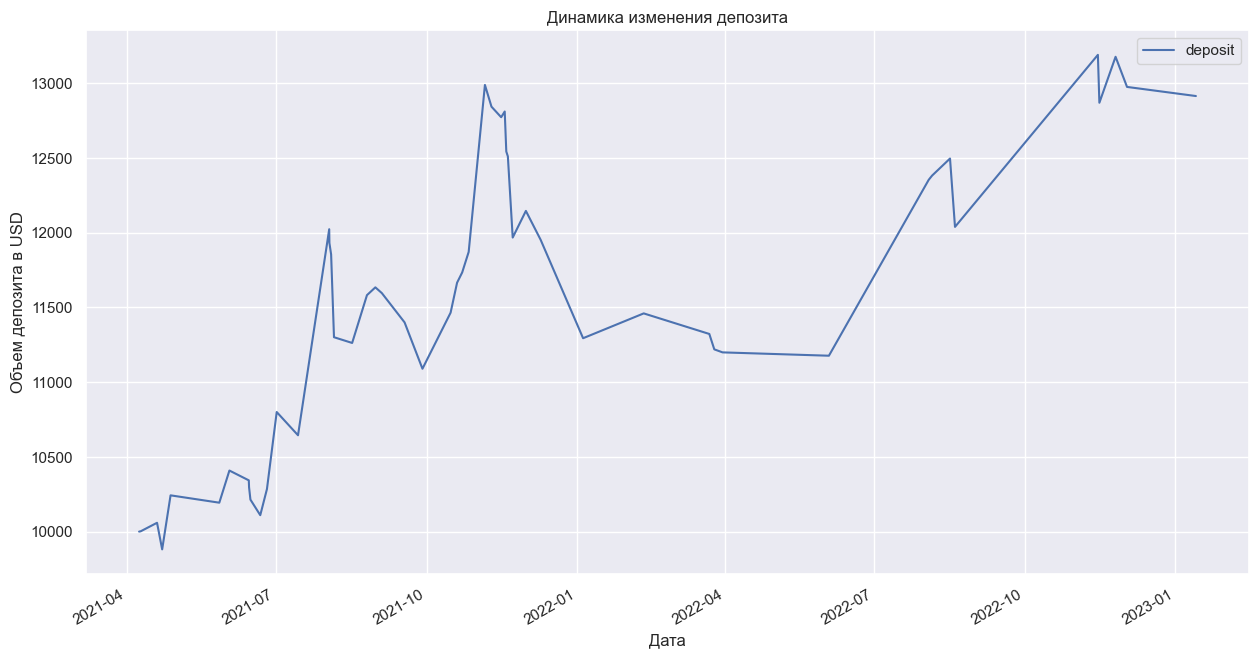

In [164]:
# посмотрим динамику изменения депозита на графике
depo_history.plot(kind='line', x='date', y='deposit')
plt.xlabel('Дата')
plt.ylabel(f'Объем депозита в {currency}')
plt.title('Динамика изменения депозита');

## Результаты

Для оценки эффективности стратегии недостаточно добиться положительного финансового результата (прибыли), необходимо обратить внимание на динамику рынка за выбранный период. Посчитаем финансовый результат в случае, если бы мы просто купили акции и держали в течение всего выбранного периода (инвестиционная стратегия), после чего сравним с результатами торговой стратегии.

In [165]:
# произведем расчет прибыльности/убыточности стратегии в % годовых
years = (data.iloc[-1][0] - data.iloc[0][0]) # вычислим период в годах, в течение которого применяли нашу стратегию
years = years.days / 365

In [166]:
print('Анализируемый период с {} по {}'.format(datetime.strptime(date_from, '%Y-%m-%d').strftime('%d/%m/%Y'), date.today().strftime('%d/%m/%Y')))
print('Рассматриваемый временной интервал (таймфрейм): {}'.format(interval))
print('-----------------------------------')
print('Всего сделок за указанный период: {}'.format(len(join_data)) )
print('Прибыльных: {}'.format(len(join_data[join_data.profit == True])  ))
print('Убыточных: {}'.format(len(join_data[join_data.profit == False]) ))
print('Максимальная прибыль одной сделки {} %'.format( round(join_data.percent.max(), 1)   ))
print('Максимальный убыток одной сделки {} %'.format( round(join_data.percent.min(), 1)   ))
print('Средняя прибыль/убыток сделки {} %'.format( round(join_data.percent.mean(),2)) )
print('-----------------------------------')
print('За указанный период цена акции {} изменилась с {} до {} {}' \
      .format(stock, data.open[0], data.close.iloc[-1], currency))
print('Изменение депозита в случае инвестиции в акции данной компании составило {} %' \
     .format(round((data.close.iloc[-1] / data.open[0]) *100 - 100, 2)))
print('Прибыльность/убыточность инвестиционной стратегии: {} % годовых' \
      .format(round((data.close.iloc[-1] / data.open[0] *100 - 100) / years, 2)))
print('-----------------------------------')
print('Депозит при торговой стратегии изменился с {} до {} {}'.format(round(start_depo, 2), round(depo[-1], 2), currency))
print('Изменение депозита при торговой стратегии составило {} %'.format(round((deposit / start_depo * 100 - 100), 2)))
print('Прибыльность/убыточность торговой стратегии: {} % годовых'.format(round((deposit / start_depo * 100 - 100) / years, 2)))
print('-----------------------------------')
if round((data.close.iloc[-1] / data.open[0] *100 - 100) / years, 2) > round((deposit / start_depo * 100 - 100) / years, 2):
    print('За указанный период инвестиционная стратегия оказалась эффективнее')
else:
    print('За указанный период торговая стратегия оказалась эффективнее')

Анализируемый период с 01/02/2021 по 16/01/2023
Рассматриваемый временной интервал (таймфрейм): 1h
-----------------------------------
Всего сделок за указанный период: 51
Прибыльных: 22
Убыточных: 29
Максимальная прибыль одной сделки 13.0 %
Максимальный убыток одной сделки -5.5 %
Средняя прибыль/убыток сделки 0.56 %
-----------------------------------
За указанный период цена акции AMD изменилась с 80.36 до 71.0 USD
Изменение депозита в случае инвестиции в акции данной компании составило -11.65 %
Прибыльность/убыточность инвестиционной стратегии: -6.33 % годовых
-----------------------------------
Депозит при торговой стратегии изменился с 10000 до 12913.87 USD
Изменение депозита при торговой стратегии составило 29.14 %
Прибыльность/убыточность торговой стратегии: 15.83 % годовых
-----------------------------------
За указанный период торговая стратегия оказалась эффективнее
